In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from pathlib import Path
from func import get_train_transform, show
from transformers import DetrFeatureExtractor, DetrForObjectDetection, TrainingArguments, Trainer

In [2]:
path_train = Path.home() / 'OneDrive - Seagroup/ai/computer_vison/Uno Cards.v2-raw.coco/train'
path_test = Path.home() / 'OneDrive - Seagroup/ai/computer_vison/Uno Cards.v2-raw.coco/test'
dataset = CocoDetection(path_train, str(path_train / '_annotations.coco.json'))

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


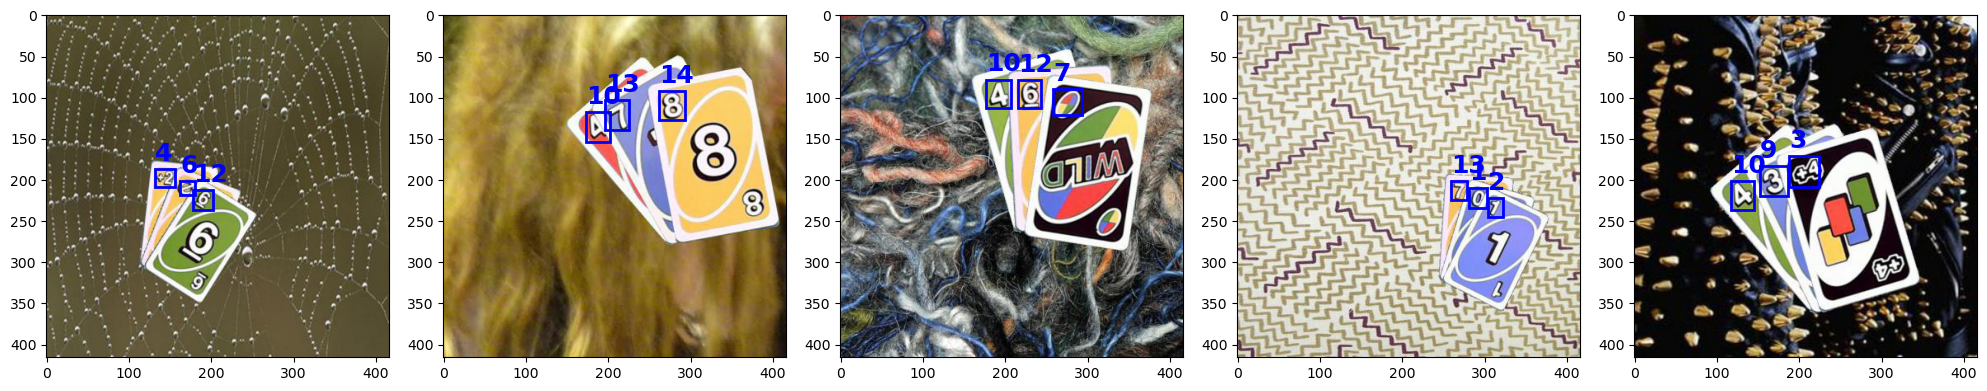

In [3]:
show(dataset)

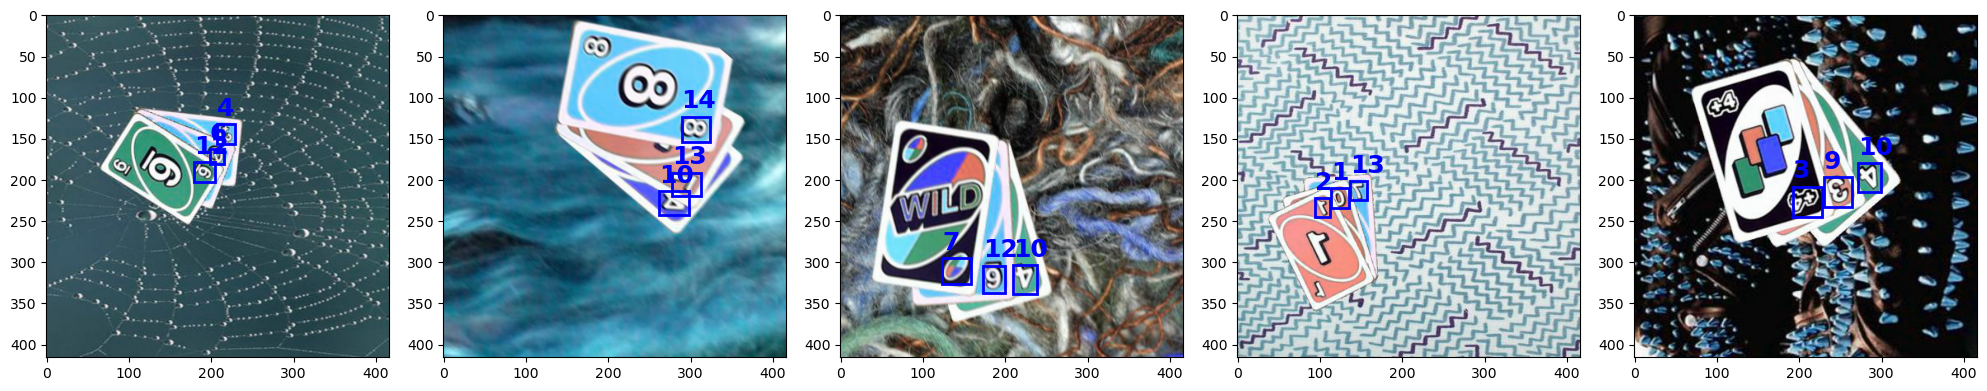

In [4]:
import albumentations as A

transform = A.Compose(
        [
            A.Flip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ],
        bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])
    )

show(dataset, 5, transform)

In [5]:
class CustomDataset(CocoDetection):
    def __init__(self, img_folder, feature_extractor):
        annot_file = img_folder / '_annotations.coco.json'
        super(CustomDataset, self).__init__(img_folder, annot_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        img, target = super(CustomDataset, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        for k in encoding.keys():
            encoding[k] = encoding[k][0]
        return encoding


checkpoint = "facebook/detr-resnet-50"
image_processor = DetrFeatureExtractor.from_pretrained(checkpoint)

train_dataset = CustomDataset(img_folder=path_train, feature_extractor=image_processor)
test_dataset = CustomDataset(img_folder=path_test, feature_extractor=image_processor)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item['labels'] for item in batch]

    batch = {'pixel_values': encoding['pixel_values'], 'pixel_mask': encoding['pixel_mask'], 'labels': labels}
    return batch


batch_size = 8
num_workers = 4
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size)

In [7]:
id2label = {k: v['name'] for k, v in train_dataset.coco.cats.items()}
label2id = {v['name']: k for k, v in train_dataset.coco.cats.items()}
model = DetrForObjectDetection.from_pretrained(
    checkpoint,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
training_args = TrainingArguments(
    output_dir="detr-resnet-50_fine_tuned",
    per_device_train_batch_size=batch_size,
    num_train_epochs=3,
    lr_scheduler_type='cosine',
    weight_decay=.01,
    fp16=True,
    logging_steps=200,
    learning_rate=1e-3,
    save_total_limit=2,
    push_to_hub=False,
    logging_dir=None,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=image_processor,
)

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Using cuda_amp half precision backend
C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6295
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2361
  Number of trainable parameters = 41290261
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: kevinkhang. Use `wandb login --relogin` to force relogin


Step,Training Loss


ValueError: boxes1 must be in [x0, y0, x1, y1] (corner) format, but got tensor([[0.7222, 0.3711, 0.7417, 0.4717],
        [0.6104, 0.2239, 0.6377, 0.3884],
        [0.7822, 0.4016, 0.8066, 0.5088],
        ...,
        [0.7393, 0.2632, 0.7705, 0.3999],
        [0.7642, 0.3545, 0.7925, 0.4858],
        [0.7192, 0.2876, 0.7485, 0.4189]], device='cuda:0',
       dtype=torch.float16)

In [16]:
results = trainer.evaluate(test_dataloader)

***** Running Evaluation *****
  Num examples = 113
  Batch size = 8


TypeError: 'DataLoader' object is not subscriptable

In [52]:
checkpoint = "detr-resnet-50_fine_tuned"
image_processor = DetrFeatureExtractor.from_pretrained(checkpoint)
model = DetrForObjectDetection.from_pretrained(
    checkpoint,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to('cuda')

In [104]:
import torch
from tqdm import tqdm
device = 'cuda'

test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=1)
for idx, batch in enumerate(tqdm(test_dataloader)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = {target['image_id'].item(): output for target, output in zip(labels, res)}
    break

  0%|                                                                                          | 0/899 [00:00<?, ?it/s]


In [100]:
orig_target_sizes

tensor([[416, 416]], device='cuda:0')

In [103]:
outputs.pred_boxes.shape

torch.Size([1, 100, 4])

In [50]:
orig_target_sizes[0][::-1]

ValueError: step must be greater than zero

In [25]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset)

ImportError: cannot import name 'get_coco_api_from_dataset' from 'datasets' (C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\datasets\__init__.py)

In [22]:
outputs.logits.shape

torch.Size([8, 100, 17])

In [24]:
outputs

DetrObjectDetectionOutput(loss=tensor(1.0897), loss_dict={'loss_ce': tensor(0.9036), 'loss_bbox': tensor(0.0061), 'loss_giou': tensor(0.0777), 'cardinality_error': tensor(3.)}, logits=tensor([[[-3.6090e+00, -1.6788e+00, -8.2918e-01,  ..., -2.3486e+00,
          -1.8875e+00,  9.2994e+00],
         [-4.4016e+00,  6.2949e-02, -3.1809e-01,  ...,  1.3634e-01,
          -4.9949e-02,  2.3300e+00],
         [-4.5826e+00, -1.3050e+00, -2.5058e-01,  ..., -1.3117e+00,
          -8.0082e-01,  6.4619e+00],
         ...,
         [-4.0351e+00,  1.5410e-01, -3.8820e-01,  ...,  1.5796e-01,
          -1.3279e-01,  2.2183e+00],
         [-3.7560e+00, -1.5790e+00, -1.0881e+00,  ..., -2.1133e+00,
          -1.6997e+00,  9.0534e+00],
         [-4.0293e+00,  1.1975e-01, -3.7667e-01,  ...,  1.7696e-01,
          -7.0155e-02,  2.1581e+00]],

        [[-3.8892e+00, -1.5634e+00, -7.9204e-01,  ..., -2.4212e+00,
          -1.7387e+00,  8.8768e+00],
         [-4.6847e+00, -4.2953e-01,  1.2519e+00,  ..., -2.8218e-0

In [ ]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

In [ ]:
# from lightning import LightningModule
# from transformers import DetrForObjectDetection
# import torch


# class Detr(LightningModule):
#     def __init__(self, lr, lr_backbone, weight_decay):
#         super().__init__()
#         # replace COCO classification head with custom head
#         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
#                                                          num_labels=len(id2label),
#                                                          ignore_mismatched_sizes=True)
#         self.lr = lr
#         self.lr_backbone = lr_backbone
#         self.weight_decay = weight_decay

#     def forward(self, pixel_values, pixel_mask):
#         outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
#         return outputs

#     def common_step(self, batch, batch_idx):
#         pixel_values = batch["pixel_values"]
#         pixel_mask = batch["pixel_mask"]
#         labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
#         outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
#         loss = outputs.loss
#         loss_dict = outputs.loss_dict
#         return loss, loss_dict

#     def training_step(self, batch, batch_idx):
#         loss, loss_dict = self.common_step(batch, batch_idx)
#         self.log("training_loss", loss)
#         for k,v in loss_dict.items():
#             self.log("train_" + k, v.item())

#         return loss

#     def validation_step(self, batch, batch_idx):
#         loss, loss_dict = self.common_step(batch, batch_idx)
#         self.log("validation_loss", loss)
#         for k,v in loss_dict.items():
#             self.log("validation_" + k, v.item())
#         return loss

#     def configure_optimizers(self):
#         param_dicts = [
#             {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
#             {"params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad], "lr": self.lr_backbone},
#         ]
#         return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

#     def train_dataloader(self):
#         return train_dataloader

#     def val_dataloader(self):
#         return val_dataloader